# Finding EMIT L2B Data

**Summary**

This notebook demonstrates how to search for Earth Mineral dust source Investigation (EMIT) L2B Estimated Mineral Identification and Band Depth and Uncertainty (EMITL2BMIN) data. This data is available in the NASA Earthdata Cloud, to download or stream, and can be found by querying the NASA Earthdata Common Metadata Repository (CMR) API, or using the [Earthdata Search]() interface. In this example we will use the `earthaccess` Python library, which abstracts the NASA CMR API, providing an easy way to search and review results programatically, and manages authentication credentials to simplify the user experience when streaming or downloading data.

<div>
<img src="../../img/finding_data_mineral_scenes.png" width="750"/>
</div>

**Background**

The EMIT instrument is an imaging spectrometer that measures light in visible and infrared wavelengths. These measurements display unique spectral signatures that correspond to the composition on the Earth's surface. The EMIT mission focuses specifically on mapping the composition of minerals to better understand the effects of mineral dust throughout the Earth system and human populations now and in the future. More details about EMIT and its associated products can be found in the **README.md** and on the [EMIT website](https://earth.jpl.nasa.gov/emit/).

The [EMITL2BMIN](https://doi.org/10.5067/EMIT/EMITL2BMIN.001) data product provides estimated mineral identification, band depths and uncertainty in a spatially raw, non-orthocorrected format. Two spectral groups, which correspond to different regions of the spectra, are identified independently and often co-occur are used to identify minerals. These estimates are generated using the [Tetracorder system](https://www.usgs.gov/publications/tetracorder-user-guide-version-44?_gl=1*1eoj33d*_ga*MTU3MTA3ODgxNS4xNjQ5MTg1MDgx*_ga_0YWDZEJ295*MTY4NjkyNTg0Mi40NC4xLjE2ODY5MjU4NzMuMC4wLjA.)([code](https://github.com/PSI-edu/spectroscopy-tetracorder)) and are based on [EMITL2ARFL](https://doi.org/10.5067/EMIT/EMITL2ARFL.001) reflectance values. The product also consists of an EMIT_L2B_MINUNCERT file, which provides band depth uncertainty estimates calculated using surface Reflectance Uncertainty values from the [EMITL2ARFL](https://doi.org/10.5067/EMIT/EMITL2ARFL.001) data product. The band depth uncertainties are presented as standard deviations, and the fit score for each mineral identification is also provided as the coefficient of determination (r<sup>2</sup>) of the match between the continuum normalized library reference and the continuum normalized observed spectrum. Associated metadata indicates the name and reference information for each identified mineral, and additional information about aggregating minerals into different categories, and the code used for product generation is available in the [emit-sds-l2b repository](https://github.com/emit-sds/emit-sds-l2b).

**Disclaimer**

The [EMIT_L2B_MIN](https://doi.org/10.5067/EMIT/EMITL2BMIN.001) product is generated to support the EMIT mission objectives of constraining the sign of dust related radiative forcing. Ten mineral types are the core focus of this work: Calcite, Chlorite, Dolomite, Goethite, Gypsum, Hematite, Illite+Muscovite, Kaolinite, Montmorillonite, and Vermiculite. A future product will aggregate these results for use in Earth System Models. Additional minerals are included in this product for transparency but were not the focus of this product. Further validation is required to use these additional mineral maps, particularly in the case of resource exploration. Similarly, the separation of minerals with similar spectral features, such as a fine-grained goethite and hematite, is an area of active research. The results presented here are an initial offering, but the precise categorization is likely to evolve over time, and the limits of what can and cannot be separated on the global scale is still being explored. The user is encouraged to read the [Algorithm Theoretical Basis Document (ATBD)](https://lpdaac.usgs.gov/documents/1659/EMITL2B_ATBD_v1.pdf) for more details.  

**Requirements**

 - [NASA Earthdata Account](https://urs.earthdata.nasa.gov/home). This is free and can be set up quickly.  
 - *No Python setup requirements if connected to the workshop cloud instance!*  
 - **Local Only** Set up Python Environment - See **setup_instructions.md** in the `/setup/` folder to set up a local compatible Python environment 

**Learning Objectives**
- How to get information about data collections using `earthaccess`
- How to query for EMIT L2B Mineralogy data using spatiotemporal parameters
- How to create a geodataframe from the search results
- How to further filter and save results URLs to a list.

**Tutorial Outline**

1. Setup  
2. Searching for EMIT L2B Mineralogy Data
3. Advanced Filtering
4. Visualizing Data
5. Creating a List of Results and Asset URLs
6. Streaming or Downloading Data

## 1. Setup

Import the required Python libraries.

In [1]:
# Import required libraries
import os
import sys
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import math

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt
import matplotlib.cm as cm

sys.path.append('../modules/')
from tutorial_utils import list_metadata_fields, results_to_geopandas, convert_bounds

### 1.2 NASA Earthdata Login Credentials

To download or stream NASA data you will need an Earthdata account, you can create one [here](https://urs.earthdata.nasa.gov/home). Searching We will use the `login` function from the `earthaccess` library for authentication before downloading at the end of the notebook. This function can also be used to create a local `.netrc` file if it doesn't exist or add your login info to an existing `.netrc` file. If no Earthdata Login credentials are found in the `.netrc` you'll be prompted for them. This step is not necessary to conduct searches but is needed to download or stream data.

## 2. Searching for EMIT L2B Mineralogy Data

To find data we will use the [`earthaccess` Python library](https://github.com/nsidc/earthaccess). `earthaccess` searches [NASA Common Metadata Repository (CMR) API](), a metadata system that catalogs Earth Science data and associated metadata records. The results can then be used to download granules or generate lists of granule search result URLs.

Using `earthaccess` we can search based on the attributes of a granule, which can be thought of as a spatiotemporal scene from an instrument containing multiple assets (ex: Reflectance, Reflectance Uncertainty, Masks for the EMIT L2A Reflectance Collection, and EMIT ). When conducting a search we can provide a product, in this case the mineralogy product, a date-time range, and spatial constraints. This process can also be used with other EMIT products, other NASA collections.

### 2.1 Querying for Datasets

Our first step in searching for data is determining which collection (e.g. EMIT L2A Estimated Surface Reflectance Uncertainty and Masks, EMIT L2B Estimated Mineral Identification and Band Depth and Uncertainty) we want to search for. The best way to do this is using the collection `short_name` (e.g. EMITL2ARFL, EMITL2BMIN) or `concept-id`. In rare cases, the `short_name` of two collections can be the same, so we will use the `concept-id` which is a unique identifier for each collection. To find the `concept-id` we can search using some keywords.

In [2]:
# EMIT Collection Query
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2B Mineral')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()

[{
   "meta": {
     "concept-id": "C2408034484-LPCLOUD",
     "granule-count": 87550,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2BMIN",
     "EntryTitle": "EMIT L2B Estimated Mineral Identification and Band Depth and Uncertainty 60 m V001",
     "Version": "001"
   }
 },
 {
   "meta": {
     "concept-id": "C2748097305-LPCLOUD",
     "granule-count": 1748,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2BCH4ENH",
     "EntryTitle": "EMIT L2B Methane Enhancement Data 60 m V001",
     "Version": "001"
   }
 },
 {
   "meta": {
     "concept-id": "C2748088093-LPCLOUD",
     "granule-count": 1285,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMITL2BCH4PLM",
     "EntryTitle": "EMIT L2B Estimated Methane Plume Complexes 60 m V001",
     "Version": "001"
   }
 },
 {
   "meta": {
     "concept-id": "C2872578364-LPCLOUD",
     "granule-count": 402,
     "provider-id": "LPCLOUD"
   },
   "umm": {
     "ShortName": "EMIT

From this list of results we can see that the `concept-id` for the desired mineral product is `C2408034484-LPCLOUD`. We can use this to define one of our search arguments.

In [3]:
concept_id = 'C2408034484-LPCLOUD'

### 2.2 Define Temporal Range

For our date range, we'll look at all EMIT data collected over 2023. The `date_range` can be specified as a pair of dates, start and end (up to, not including).

In [4]:
date_range = ('2023-01-01','2024-01-01')

### 2.3 Define Spatial Region of Interest

For this example, our spatial region of interest will be the area around Cuprite, NV. A location where there have been several previous mineralogy studies. We can define this region using a rectangular polygon. If you want to make a polygon for a different region, you can use a tool like [geojson.io](http://geojson.io/).

Open the `geojson` as a `geodataframe`, and check the coordinate reference system (CRS) of the data.

In [5]:
roi_gdf = gpd.read_file('../../data/cuprite_bbox.geojson')
roi_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
roi_gdf

,geometry
0,"POLYGON ((-117.24309 37.59129, -117.24309 37.5..."


We can see this `geodataframe` consists of a single polygon which we want to include in our search, but the geometry is the only information contained in the file, so lets add a column for the site name, and set the value to "Cuprite".

In [7]:
roi_gdf['Name'] = 'Cuprite'

In [8]:
roi_gdf

,geometry,Name
0,"POLYGON ((-117.24309 37.59129, -117.24309 37.5...",Cuprite


We can visualize the ROI using the `folium` library and the `explore` function from `geopandas`. First, we'll create a helper function. Then we will create a new map, using Google Maps tiles as our basemap, and add the polygon to the map. We'll also use our `convert_bounds` helper function to limit the map view to roughly the extent of the polygon.

In [9]:
# Function to convert a bounding box for use in leaflet notation

def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

In [10]:
fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Add roi geodataframe
roi_gdf.explore(
    "Name",
    popup=True,
    categorical=True,
    cmap='Set3',
    style_kwds=dict(opacity=0.7, fillOpacity=0.4),
    name="Regions of Interest",
    m=map1
)

map1.add_child(folium.LayerControl())
map1.fit_bounds(bounds=convert_bounds(roi_gdf.unary_union.bounds))
display(fig)

In our `earthaccess` search, we will use the `polygon` argument to find where this geometry intersects with the footprint of the EMIT scenes. To do this, we need to create a list of exterior polygon vertices in counter-clockwise order to submit in our search.

In [11]:
# Use orient to place vertices in counter-clockwise order
roi = orient(roi_gdf.geometry[0], sign = 1.0)
# Put the exterior coordinates in a list
roi = list(roi.exterior.coords)
roi

[(-117.24309240198033, 37.59129385913785),
 (-117.24309240198033, 37.50102626452812),
 (-117.14631968357332, 37.50102626452812),
 (-117.14631968357332, 37.59129385913785),
 (-117.24309240198033, 37.59129385913785)]

After we have all of the pieces: *spatial extent*, *temporal range*, and *concept-id*, we can perform a search. Note that we are limiting our search 500 results using the `count` argument, which doesn't matter here.

In [12]:
results = earthaccess.search_data(
    concept_id=concept_id,
    polygon=roi,
    temporal=date_range,
    count=500
)

Granules found: 9


Our search returned 9 results, which we can convert to a `geodataframe` for further filtering and analysis.

In [14]:
results

[Collection: {'ShortName': 'EMITL2BMIN', 'Version': '001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -116.86429595947266, 'Latitude': 37.96258544921875}, {'Longitude': -117.72748565673828, 'Latitude': 37.362998962402344}, {'Longitude': -117.27104949951172, 'Latitude': 36.70587921142578}, {'Longitude': -116.4078598022461, 'Latitude': 37.30546569824219}, {'Longitude': -116.86429595947266, 'Latitude': 37.96258544921875}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-01-29T21:14:07Z', 'EndingDateTime': '2023-01-29T21:14:19Z'}}
 Size(MB): 75.91049480438232
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230129T211407_2302914_008/EMIT_L2B_MIN_001_20230129T211407_2302914_008.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230129T211407_2302914_008/EMIT_L2B_MINUNCERT_001_20230129T211407_2

## 3. Advanced Filtering

Now that we have some results, we will place them into a geodataframe that includes links to browse imagery and the files, so we can do some more advanced filtering of the data.

List the metadata fields available in the search results.

In [15]:
list_metadata_fields(results)

['size',
 'concept-type',
 'concept-id',
 'revision-id',
 'native-id',
 'collection-concept-id',
 'provider-id',
 'format',
 'revision-date',
 '_beginning_date_time',
 '_ending_date_time',
 '_granule_ur',
 '_additional_attributes',
 '_gpolygons',
 '_provider_dates',
 '_short_name',
 '_version',
 '_pgename',
 '_pgeversion',
 '_related_urls',
 '_cloud_cover',
 '_day_night_flag',
 '_archive_and_distribution_information',
 '_production_date_time',
 '_platforms',
 '_url',
 '_name',
 '_version']

Some datasets have unique metadata that we can choose to include when we use our `results_to_geopandas` function from the `tutorial_utils.py` module to create a geodataframe. Below is a list of default fields. We can also include additional fields by passing them as a list to the `fields` argument.

default_fields = [  
        "size",  
        "concept_id",  
        "dataset-id",  
        "native-id",  
        "provider-id",  
        "_related_urls",  
        "_single_date_time",  
        "_beginning_date_time",  
        "_ending_date_time",  
        "geometry",  
    ]

For example, `_cloud_cover` is not always available. We can add it to the default fields of this function by adding it to a `fields` argument in list form.

In [16]:
results_gdf = results_to_geopandas(results, fields=['_cloud_cover'])

Add an index column so we can reference it using the `explore` function from `geopandas`

In [17]:
# Specify index so we can reference it with gdf.explore()
results_gdf['index']=results_gdf.index

In [18]:
results_gdf

,size,native-id,provider-id,_beginning_date_time,_ending_date_time,_related_urls,_cloud_cover,geometry,index
0,75.910495,EMIT_L2B_MIN_001_20230129T211407_2302914_008,LPCLOUD,2023-01-29T21:14:07Z,2023-01-29T21:14:19Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,99,"POLYGON ((-116.86430 37.96259, -117.72749 37.3...",0
1,101.561633,EMIT_L2B_MIN_001_20230427T173257_2311711_009,LPCLOUD,2023-04-27T17:32:57Z,2023-04-27T17:33:09Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,21,"POLYGON ((-117.79698 38.33380, -118.24942 37.6...",1
2,100.931341,EMIT_L2B_MIN_001_20230427T173309_2311711_010,LPCLOUD,2023-04-27T17:33:09Z,2023-04-27T17:33:21Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,8,"POLYGON ((-117.09042 37.85598, -117.54974 37.1...",2
3,101.904746,EMIT_L2B_MIN_001_20230804T191650_2321613_007,LPCLOUD,2023-08-04T19:16:50Z,2023-08-04T19:17:02Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,4,"POLYGON ((-117.15681 38.27825, -118.03522 37.6...",3
4,102.344337,EMIT_L2B_MIN_001_20230808T173953_2322012_011,LPCLOUD,2023-08-08T17:39:53Z,2023-08-08T17:40:05Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,6,"POLYGON ((-116.72791 37.98892, -117.59428 37.3...",4
5,101.627942,EMIT_L2B_MIN_001_20231023T183905_2329612_009,LPCLOUD,2023-10-23T18:39:05Z,2023-10-23T18:39:17Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,74,"POLYGON ((-117.73664 38.31432, -118.18502 37.6...",5
6,100.521277,EMIT_L2B_MIN_001_20231023T183917_2329612_010,LPCLOUD,2023-10-23T18:39:17Z,2023-10-23T18:39:29Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,32,"POLYGON ((-117.02521 37.83480, -117.48288 37.1...",6
7,101.653114,EMIT_L2B_MIN_001_20231201T201058_2333513_006,LPCLOUD,2023-12-01T20:10:58Z,2023-12-01T20:11:10Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,65,"POLYGON ((-117.53461 38.28449, -118.40948 37.6...",7
8,170.777638,EMIT_L2B_MIN_001_20231201T201110_2333513_007,LPCLOUD,2023-12-01T20:11:10Z,2023-12-01T20:11:31Z,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,53,"POLYGON ((-116.26720 39.11488, -117.70616 38.1...",8


Filter the results geodataframe by cloud cover. We'll use a cloud cover of 10% as our threshold.

In [19]:
# Filter Results
results_gdf = results_gdf[results_gdf['_cloud_cover'] < 10]
results_gdf.reset_index(drop=True, inplace=True)

Visualize the filtered results by iterating over the rows of the geodataframe and adding the geometry to the map. We do this instead of the `explore` function, so we add separate layers for each, allowing use to add or remove them using the `LayerControl` widget.

In [20]:
# Set up Figure and Basemap tiles
fig = Figure(width="1080px",height="540")
map1 = folium.Map(tiles=None)
folium.TileLayer(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',name='Google Satellite', attr='Google', overlay=True).add_to(map1)
folium.TileLayer(tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.png',
                name='ESRI World Imagery',
                attr='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
                overlay='True').add_to(map1)
fig.add_child(map1)


# Create a color map for the results
cmap = cm.get_cmap('Set3')
n = len(results_gdf['native-id'].unique())
colors = [cmap(i) for i in range(n)]
colors = [cm.colors.rgb2hex(color) for color in colors]

# Add Search Results by Row
for index, row in results_gdf.iterrows():
    color = colors[index % len(colors)]
    folium.GeoJson(row.geometry, name = row['native-id'],style_function=lambda feature, color=color: {'color': color, 'fillColor': color}).add_to(map1)

folium.GeoJson(roi_gdf,
                name='Cuprite_ROI',
                ).add_to(map1)

# Zoom to Data
map1.fit_bounds(bounds=convert_bounds(results_gdf.unary_union.bounds))
# Add Layer controls
map1.add_child(folium.LayerControl(collapsed=False))
display(fig)

C:\Users\ebolch\AppData\Local\Temp\1\ipykernel_16232\2570979738.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Set3')


View the related urls for the first result. We can see that there are multiple assets available for each result, including the mineralogy data, uncertainty data, and browse images, as well as multiple ways to access the data, https or s3 links.

In [21]:
results_gdf._related_urls[0]

[{'URL': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230427T173309_2311711_010/EMIT_L2B_MIN_001_20230427T173309_2311711_010.nc',
  'Description': 'Download EMIT_L2B_MIN_001_20230427T173309_2311711_010.nc',
  'Type': 'GET DATA'},
 {'URL': 's3://lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230427T173309_2311711_010/EMIT_L2B_MIN_001_20230427T173309_2311711_010.nc',
  'Description': 'This link provides direct download access via S3 to the granule',
  'Type': 'GET DATA VIA DIRECT ACCESS'},
 {'URL': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230427T173309_2311711_010/EMIT_L2B_MINUNCERT_001_20230427T173309_2311711_010.nc',
  'Description': 'Download EMIT_L2B_MINUNCERT_001_20230427T173309_2311711_010.nc',
  'Type': 'GET DATA'},
 {'URL': 's3://lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230427T173309_2311711_010/EMIT_L2B_MINUNCERT_001_20230427T173309_2311711_010.nc',
  'Desc

We can use a function to return the asset URLs for a given result. This function will return a dictionary with the asset names as keys and the URLs as values.

In [22]:
def get_asset_url(row,asset, key='Type',value='GET DATA'):
    """
    Retrieve a url from the list of dictionaries for a row in the _related_urls column.
    Asset examples: CH4PLM, CH4PLMMETA, RFL, MASK, RFLUNCERT 
    """
    # Add _ to asset so string matching works
    asset = f"_{asset}_"
    # Retrieve URL matching parameters
    for _dict in row['_related_urls']:
        if _dict.get(key) == value and asset in _dict['URL'].split('/')[-1]:
            return _dict['URL']

Apply the function for to the results geodataframe to get the asset URLs for each result for the `L2B_MIN` asset.

In [23]:
# Iterate over rows in the plm_gdf and get the mineral urls and store them in a list
min_urls = results_gdf.apply(lambda row: get_asset_url(row, asset='L2B_MIN'), axis=1).tolist()
min_urls

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230427T173309_2311711_010/EMIT_L2B_MIN_001_20230427T173309_2311711_010.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230804T191650_2321613_007/EMIT_L2B_MIN_001_20230804T191650_2321613_007.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230808T173953_2322012_011/EMIT_L2B_MIN_001_20230808T173953_2322012_011.nc']

We can repeat this for the uncertainty URLs.

In [24]:
min_unc_urls = results_gdf.apply(lambda row: get_asset_url(row, asset='L2B_MINUNCERT'), axis=1).tolist()
min_unc_urls

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230427T173309_2311711_010/EMIT_L2B_MINUNCERT_001_20230427T173309_2311711_010.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230804T191650_2321613_007/EMIT_L2B_MINUNCERT_001_20230804T191650_2321613_007.nc',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230808T173953_2322012_011/EMIT_L2B_MINUNCERT_001_20230808T173953_2322012_011.nc']

With some knowledge of how the granules and assets are neamed, we can grab the rgb browse images to get an idea of what the location looks like. First retrieve the browse images for the mineral product. These, show the mineral band depth only. 

In [25]:
min_png = results_gdf.apply(lambda row: get_asset_url(row, asset='L2B_MIN', value='GET RELATED VISUALIZATION'), axis=1).tolist()
min_png

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230427T173309_2311711_010/EMIT_L2B_MIN_001_20230427T173309_2311711_010.png',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230804T191650_2321613_007/EMIT_L2B_MIN_001_20230804T191650_2321613_007.png',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/EMITL2BMIN.001/EMIT_L2B_MIN_001_20230808T173953_2322012_011/EMIT_L2B_MIN_001_20230808T173953_2322012_011.png']

With some slight changes to these, we can retrieve the RGB browse images from the L2A Reflectance product.

In [26]:
# Replace Collection ID
rgb_urls = [s.replace('EMITL2BMIN', 'EMITL2ARFL') for s in min_png]
# Update Product and Asset Names
rgb_urls = [s.replace('EMIT_L2B_MIN', 'EMIT_L2A_RFL') for s in rgb_urls]
# Change file extension
#rgb_urls = [s.replace('.nc', '.png') for s in rgb_urls]
rgb_urls

['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230427T173309_2311711_010/EMIT_L2A_RFL_001_20230427T173309_2311711_010.png',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230804T191650_2321613_007/EMIT_L2A_RFL_001_20230804T191650_2321613_007.png',
 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-public/EMITL2ARFL.001/EMIT_L2A_RFL_001_20230808T173953_2322012_011/EMIT_L2A_RFL_001_20230808T173953_2322012_011.png']

Visualize the RGB browse images to get an idea for what the area we are investigating looks like.

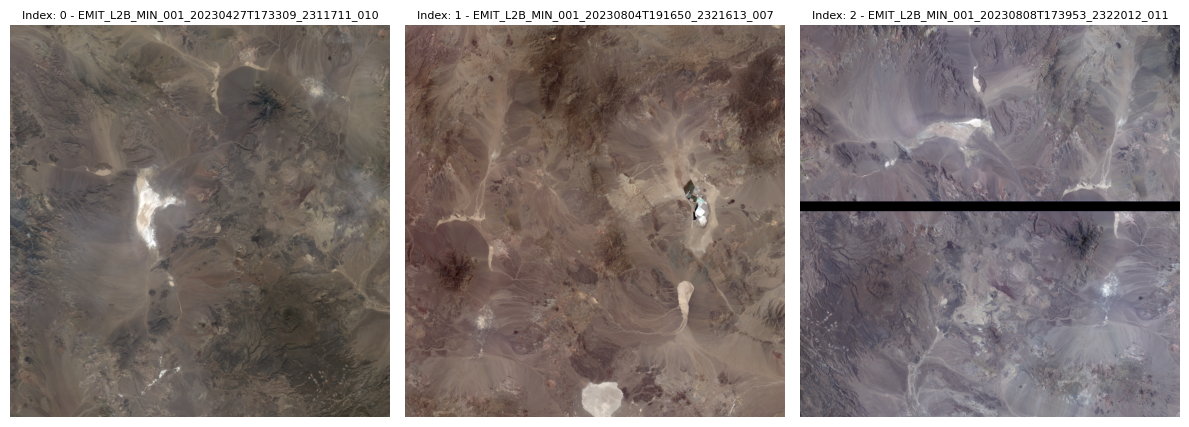

In [27]:
cols = 3
rows = math.ceil(len(results_gdf)/cols)
fig, ax = plt.subplots(rows, cols, figsize=(12,12))
ax = ax.flatten()

for _n, index in enumerate(results_gdf.index.to_list()):
    img = io.imread(rgb_urls[index])
    ax[_n].imshow(img)
    ax[_n].set_title(f"Index: {index} - {results_gdf['native-id'][index]}", fontsize=8)
    ax[_n].axis('off')
plt.tight_layout()
plt.show()

The black line in the third scene is caused by the on-board cloud masking.

## 5. Saving Lists of Results

We can save our lists of results URLs as a text file for later use, either to download the data, or stream it.

In [28]:
with open('../../data/rgb_browse_urls.txt', 'w') as f:
    for line in rgb_urls:
        f.write(f"{line}\n")

In [29]:
with open('../../data/results_urls.txt', 'w') as f:
    for line in min_urls:
        f.write(f"{line}\n")

In [30]:
with open('../../data/min_uncert_urls.txt', 'w') as f:
    for line in min_unc_urls:
        f.write(f"{line}\n")

## 6. Streaming or Downloading Data
For the workshop, we will stream the data, but either method can be used, and each has trade-offs based on the internet speed, storage space, or use case. The EMIT files are very large due to the number of bands, so operations can take some time if streaming with a slower internet connection. Since the workshop is hosted in a Cloud workspace, we can stream the data directly to the workspace.

### 6.1 Streaming Data Workflow
For an example of streaming both netCDF please see [Working with EMIT L2B Mineralogy.ipynb](Working_with_EMIT_L2B_Mineralogy.ipynb).

If you plan to stream the data, you can stop here and move to the next notebook.

### 6.2 Downloading Data Workflow
To download the scenes, we can use the earthaccess library to authenticate then download the files.

First, log into Earthdata using the login function from the earthaccess library. The persist=True argument will create a local .netrc file if it doesn’t exist, or add your login info to an existing .netrc file. If no Earthdata Login credentials are found in the .netrc you’ll be prompted for them. As mentioned in section 1.2, this step is not necessary to conduct searches, but is needed to download or stream data.

The outputs saved in section 5 can be downloading by uncommenting and running the following cells.

In [ ]:
# # Authenticate using earthaccess
# earthaccess.login(persist=True)

In [ ]:
# # Open Text File and Read Lines
# file_list = ['../../data/rgb_browse_urls.txt','../../data/results_urls.txt']
# urls = []
# for file in file_list:
#     with open(file) as f:
#         urls.extend([line.rstrip('\n') for line in f])

In [ ]:
# # Get requests https Session using Earthdata Login Info
# fs = earthaccess.get_requests_https_session()
# # Retrieve granule asset ID from URL (to maintain existing naming convention)
# for url in urls:
#     granule_asset_id = url.split('/')[-1]
#     # Define Local Filepath
#     fp = f'../../data/{granule_asset_id}'
#     # Download the Granule Asset if it doesn't exist
#     if not os.path.isfile(fp):
#         with fs.get(url,stream=True) as src:
#             with open(fp,'wb') as dst:
#                 for chunk in src.iter_content(chunk_size=64*1024*1024):
#                     dst.write(chunk)


## Contact Info:  

Email: LPDAAC@usgs.gov  
Voice: +1-866-573-3222  
Organization: Land Processes Distributed Active Archive Center (LP DAAC)¹  
Website: <https://lpdaac.usgs.gov/>  
Date last modified: 06-28-2024  

¹Work performed under USGS contract 140G0121D0001 for NASA contract NNG14HH33I. 